In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# ! pip install pgmpy

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np

import common

In [5]:
date_set_path = "../temp_sets_100/"

## callout

### Read samples

In [6]:
callout_df = common.read_csv_no_rowid(date_set_path+"callout.csv")

### Data preproces

In [7]:
# Drop useless colums
callout_df.drop(['submit_careunit', 'firstreservationtime', 'currentreservationtime'], axis=1, inplace=True)

#### Deal with null values

In [8]:
# Check null value in table
common.nan_count(callout_df)

Total columns: 20
Total rows: 73
--------------
subject_id            0
hadm_id               0
submit_wardid         0
curr_wardid           0
curr_careunit         0
callout_wardid        0
callout_service       0
request_tele          0
request_resp          0
request_cdiff         0
request_mrsa          0
request_vre           0
callout_status        0
callout_outcome       0
discharge_wardid      6
acknowledge_status    0
createtime            0
updatetime            0
acknowledgetime       5
outcometime           0
dtype: int64


#### Set the column types

In [9]:
callout_df.dtypes

subject_id              int64
hadm_id                 int64
submit_wardid           int64
curr_wardid             int64
curr_careunit          object
callout_wardid          int64
callout_service        object
request_tele            int64
request_resp            int64
request_cdiff           int64
request_mrsa            int64
request_vre             int64
callout_status         object
callout_outcome        object
discharge_wardid      float64
acknowledge_status     object
createtime             object
updatetime             object
acknowledgetime        object
outcometime            object
dtype: object

In [10]:
# Transfer some date type
callout_df['createtime'] = pd.to_datetime(callout_df['createtime'])
callout_df['updatetime'] = pd.to_datetime(callout_df['updatetime'])
callout_df['acknowledgetime'] = pd.to_datetime(callout_df['acknowledgetime'])
callout_df['outcometime'] = pd.to_datetime(callout_df['outcometime'])

In [11]:
callout_df.dtypes

subject_id                     int64
hadm_id                        int64
submit_wardid                  int64
curr_wardid                    int64
curr_careunit                 object
callout_wardid                 int64
callout_service               object
request_tele                   int64
request_resp                   int64
request_cdiff                  int64
request_mrsa                   int64
request_vre                    int64
callout_status                object
callout_outcome               object
discharge_wardid             float64
acknowledge_status            object
createtime            datetime64[ns]
updatetime            datetime64[ns]
acknowledgetime       datetime64[ns]
outcometime           datetime64[ns]
dtype: object

#### Deal with some special value

---

##  Build Network

In [12]:
from sdv.tabular import CTGAN
from sdv.constraints import FixedCombinations
from sdv.constraints import create_custom_constraint

In [13]:
callout_df.columns

Index(['subject_id', 'hadm_id', 'submit_wardid', 'curr_wardid',
       'curr_careunit', 'callout_wardid', 'callout_service', 'request_tele',
       'request_resp', 'request_cdiff', 'request_mrsa', 'request_vre',
       'callout_status', 'callout_outcome', 'discharge_wardid',
       'acknowledge_status', 'createtime', 'updatetime', 'acknowledgetime',
       'outcometime'],
      dtype='object')

### Set constraint

In [14]:
callout_df['outcometime']

0    2105-02-22 11:25:39
1    2105-02-23 18:10:02
2    2152-04-01 21:25:02
3    2104-10-19 16:40:05
4    2106-08-14 18:10:03
             ...        
68   2179-12-19 13:29:15
69   2149-03-23 14:09:01
70   2149-03-26 17:55:04
71   2152-03-07 15:43:05
72   2136-06-27 14:28:01
Name: outcometime, Length: 73, dtype: datetime64[ns]

In [15]:
a = callout_df['outcometime'] - callout_df['acknowledgetime']
a

0                NaT
1    0 days 08:09:32
2    0 days 06:07:19
3                NaT
4                NaT
           ...      
68   0 days 02:11:10
69   0 days 05:41:23
70   0 days 05:01:45
71   0 days 06:07:16
72   0 days 03:01:02
Length: 73, dtype: timedelta64[ns]

In [16]:
callout_df['outcometime'] + a

0                    NaT
1    2105-02-24 02:19:34
2    2152-04-02 03:32:21
3                    NaT
4                    NaT
             ...        
68   2179-12-19 15:40:25
69   2149-03-23 19:50:24
70   2149-03-26 22:56:49
71   2152-03-07 21:50:21
72   2136-06-27 17:29:03
Length: 73, dtype: datetime64[ns]

In [17]:
(callout_df['outcometime'] - callout_df['acknowledgetime']).apply(lambda x: x.days).max()
# (callout_df['acknowledgetime'] - callout_df['createtime']).apply(lambda x: x.seconds).min()

1.0

In [18]:
def time_is_valid(column_names, data):
    update_create = ((data['updatetime'] - data['createtime']).apply(lambda x: 0 <= x.days  <= 2))

    # acknowledge_update = \
    #     (pd.isna(data['acknowledgetime'])) | \
    #     (((pd.isna(data['acknowledgetime']) == False) & ((data['acknowledgetime'] - data['updatetime']).apply(lambda x: -1 <= x.days  <= 1))))

    # outcome_create = \
    #     (pd.isna(data['acknowledgetime']) & (callout_df['outcometime'] - callout_df['createtime']).apply(lambda x: 0 <= x.days <= 2)) | \
    #     ( \
    #         (pd.isna(data['acknowledgetime']) == False) & ((data['outcometime'] - data['acknowledgetime']).apply(lambda x: 0 <= x.days  <= 2)) \
    #     )
        
    return update_create# & acknowledge_update & outcome_create

In [19]:
def time_trasform(column_names, data):
    data['outcometime'] = data['outcometime'].astype(int) - data['acknowledgetime'].astype(int)
    data['acknowledgetime'] = data['acknowledgetime'].astype(int) - data['updatetime'].astype(int)
    data['updatetime'] = data['updatetime'].astype(int) - data['createtime'].astype(int)

    return data

def time_reverse_transform(column_names, transformed_data):
    transformed_data['updatetime'] = transformed_data['updatetime'] + transformed_data['createtime']
    transformed_data['acknowledgetime'] = transformed_data['acknowledgetime'] + transformed_data['updatetime']
    transformed_data['outcometime'] = transformed_data['outcometime'] + transformed_data['acknowledgetime']

    # print(transformed_data.head())
    return transformed_data

In [20]:
TimeProcess = create_custom_constraint(
    is_valid_fn=time_is_valid,
    transform_fn=time_trasform,
    reverse_transform_fn=time_reverse_transform
)

In [21]:
time_constraint = TimeProcess(
    column_names=['createtime', 'updatetime','acknowledgetime', 'outcometime']
)

In [22]:
constrains = [time_constraint]

### Build model

In [47]:
model = CTGAN(
    constraints=constrains, 
    # generator_lr=0.0005,
    batch_size=10000,
    cuda=True, 
    verbose=True, 
    epochs=60)

In [48]:
len(callout_df)

73

In [49]:
train_data = callout_df
model.fit(train_data)

Epoch 1, Loss G:  0.8500,Loss D: -0.0141
Epoch 2, Loss G:  0.8547,Loss D: -0.0396
Epoch 3, Loss G:  0.8435,Loss D: -0.0699
Epoch 4, Loss G:  0.8309,Loss D: -0.1196
Epoch 5, Loss G:  0.7925,Loss D: -0.1641
Epoch 6, Loss G:  0.7782,Loss D: -0.2059
Epoch 7, Loss G:  0.7623,Loss D: -0.2468
Epoch 8, Loss G:  0.7105,Loss D: -0.2885
Epoch 9, Loss G:  0.6690,Loss D: -0.3155
Epoch 10, Loss G:  0.6224,Loss D: -0.3545
Epoch 11, Loss G:  0.5723,Loss D: -0.3863
Epoch 12, Loss G:  0.4801,Loss D: -0.3777
Epoch 13, Loss G:  0.4081,Loss D: -0.3652
Epoch 14, Loss G:  0.3388,Loss D: -0.3792
Epoch 15, Loss G:  0.2377,Loss D: -0.3265
Epoch 16, Loss G:  0.1708,Loss D: -0.3128
Epoch 17, Loss G:  0.1205,Loss D: -0.3080
Epoch 18, Loss G:  0.0720,Loss D: -0.2754
Epoch 19, Loss G:  0.1188,Loss D: -0.3042
Epoch 20, Loss G:  0.1150,Loss D: -0.2396
Epoch 21, Loss G:  0.2294,Loss D: -0.3160
Epoch 22, Loss G:  0.3401,Loss D: -0.2912
Epoch 23, Loss G:  0.4222,Loss D: -0.3679
Epoch 24, Loss G:  0.4977,Loss D: -0.3702
E

In [52]:
import cloudpickle

with open(date_set_path + "100_models/" + "callout_model.pkl", 'wb') as f:
    cloudpickle.dump(model, f)

In [ ]:
# model.save(date_set_path + "100_models/" + "callout_model.pkl")

In [36]:
sample = model.sample(100)

Sampling rows:   3%|▎         | 3/100 [00:39<21:06, 13.05s/it]


In [35]:
sample.head()

,subject_id,hadm_id,submit_wardid,curr_wardid,curr_careunit,callout_wardid,callout_service,request_tele,request_resp,request_cdiff,request_mrsa,request_vre,callout_status,callout_outcome,discharge_wardid,acknowledge_status,createtime,updatetime,acknowledgetime,outcometime
0,58567,100223,54,55,CSRU,55,NMED,1,0,0,1,0,Inactive,Discharged,48.0,Acknowledged,2142-11-11 02:42:09.011450880,2142-11-13 21:03:39.599397888,2094-06-28 20:36:16.956094976,2156-01-28 16:04:16.692486144
1,569,153294,14,51,CSRU,55,MED,1,0,0,0,0,Inactive,Discharged,NaN,Acknowledged,2130-08-22 04:12:04.282944512,2130-08-23 20:18:04.484800512,2183-02-11 08:59:29.937091584,2167-08-01 07:46:15.083214848
2,46774,122216,24,9,CSRU,1,CSURG,0,0,0,0,0,Inactive,Discharged,4.0,Acknowledged,2112-12-20 15:10:19.841897984,2112-12-22 08:29:51.659505664,2093-02-20 21:31:15.940450816,2132-06-30 01:11:12.182587392
3,46105,166609,57,55,CCU,26,MED,1,0,0,1,0,Inactive,Discharged,55.0,Acknowledged,2137-02-11 04:40:28.703436800,2137-02-11 04:48:53.805082624,2129-05-06 07:23:54.901232640,2152-06-06 19:26:31.896283136
4,18583,153634,57,55,CSRU,1,MED,0,0,0,0,0,Inactive,Discharged,0.0,Acknowledged,2117-04-05 04:14:29.274714112,2117-04-07 14:37:32.023449600,2128-02-15 16:06:55.390842880,2144-05-15 16:03:18.721136640


### Process the generated data

---

## Evaluate data

In [31]:
from sdv.evaluation import evaluate

In [32]:
train_data.columns

Index(['subject_id', 'hadm_id', 'submit_wardid', 'curr_wardid',
       'curr_careunit', 'callout_wardid', 'callout_service', 'request_tele',
       'request_resp', 'request_cdiff', 'request_mrsa', 'request_vre',
       'callout_status', 'callout_outcome', 'discharge_wardid',
       'acknowledge_status', 'createtime', 'updatetime', 'acknowledgetime',
       'outcometime'],
      dtype='object')

In [37]:
evaluate(sample, train_data)

0.38380808037953645

In [41]:
sample['curr_careunit'].value_counts()

MICU    2
CSRU    1
Name: curr_careunit, dtype: int64

<AxesSubplot:>

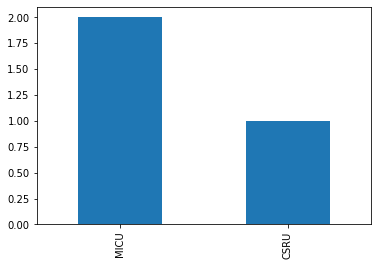

In [38]:
sample['curr_careunit'].value_counts().plot.bar()

In [40]:
train_data['curr_careunit'].value_counts()

MICU     32
TSICU    14
SICU     12
CSRU      9
CCU       6
Name: curr_careunit, dtype: int64

<AxesSubplot:>

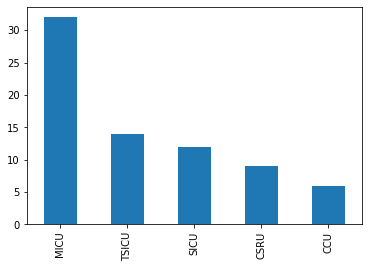

In [39]:
train_data['curr_careunit'].value_counts().plot.bar()

<AxesSubplot:xlabel='admission_type', ylabel='admission_location'>

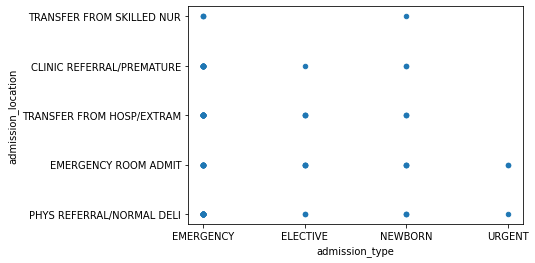

In [ ]:
sample.plot.scatter(x='admission_type',y='admission_location')

<AxesSubplot:xlabel='admission_type', ylabel='admission_location'>

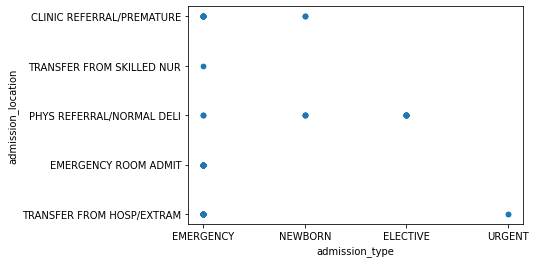

In [ ]:
train_data.plot.scatter(x='admission_type',y='admission_location')

In [ ]:
mostly_ai_data = pd.read_csv("test_syn.csv")

In [ ]:
sample.columns

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
       'edregtime', 'edouttime', 'has_chartevents_data',
       'hospital_expire_flag'],
      dtype='object')

In [ ]:
mostly_ai_data = mostly_ai_data.drop(['hospital_expire_flag'], axis=1)

In [ ]:
evaluate(mostly_ai_data, train_data.loc[:, mostly_ai_data.columns], metrics=['DiscreteKLDivergence'])

0.5564527888761744

In [ ]:
evaluate(sample.loc[:, mostly_ai_data.columns], train_data.loc[:, mostly_ai_data.columns], metrics=['DiscreteKLDivergence'])

0.434181554015113

In [ ]:
evaluate(mostly_ai_data, train_data.loc[:, mostly_ai_data.columns], metrics=['ContinuousKLDivergence'])

0.29878381842255286

In [ ]:
evaluate(sample.loc[:, mostly_ai_data.columns], train_data.loc[:, mostly_ai_data.columns], metrics=['ContinuousKLDivergence'])

0.5400340429220125